## Import Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(13)
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)

1.0.2
1.20.3
1.3.3


## Import data

In [2]:
df = pd.read_csv("../data/JFP Credential Data_All_Journals_Final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081 entries, 0 to 5080
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         5081 non-null   object
 1   Abstract      3623 non-null   object
 2   Authors       4936 non-null   object
 3   documentType  5081 non-null   object
 4   pub_month     4811 non-null   object
 5   pub_year      5081 non-null   int64 
 6   pubtitle      5081 non-null   object
 7   subjectTerms  3650 non-null   object
 8   Database      5081 non-null   object
dtypes: int64(1), object(8)
memory usage: 357.4+ KB


## Extract Credentials

In [4]:
df["Credentials"] = (df
                     .Authors
                     .apply(lambda x: re.findall(r"(CFP|PhD|CFA|JD|CPA|CLU|ChFC|LLM|AIF|CRC)", str(x)))
                     .apply(lambda x: np.nan if len(x) == 0 else x)
                     )

## Group Credentials into target groups

In [5]:
def target_grouping(x):
    if type(x) != list:
        return np.nan
    elif "PhD" in set(x):
        return "Academic"
    else:
        return "Practitioner"

df["target_grouping"] = df.Credentials.apply(target_grouping)

## Drop nulls

In [6]:
df = df.dropna(subset=["target_grouping", "Abstract"]).reset_index(drop=True)

## Split Train and Target

In [7]:
X = df.Abstract
y = df.target_grouping

In [8]:
X.shape, y.shape

((2408,), (2408,))

In [9]:
y.value_counts()

Practitioner    1504
Academic         904
Name: target_grouping, dtype: int64

## Encode Target

In [10]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [11]:
encoder.classes_

array(['Academic', 'Practitioner'], dtype=object)

## Create Pipeline

In [12]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    #("scaler", StandardScaler(with_mean=False))
])

models = [LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier()]

pipelines = [Pipeline([
    ("vectorizer", TfidfVectorizer()),
    #("scaler", StandardScaler(with_mean=False)),
    ("classifier", model)
    ]) for model in models]

In [13]:
pipelines

[Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('classifier', LogisticRegression())]),
 Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('classifier', MultinomialNB())]),
 Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('classifier', DecisionTreeClassifier())]),
 Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('classifier', RandomForestClassifier())])]

## Train/test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

In [15]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1685 1685
723 723


## Train and test models

In [17]:
encoder.classes_

array(['Academic', 'Practitioner'], dtype=object)

In [18]:
classification_reports = []
confusion_matrices = []

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    classification_reports.append(classification_report(y_true=y_test, 
                                                        y_pred=y_pred, 
                                                        target_names=encoder.classes_, 
                                                        output_dict=True))
    
    confusion_matrices.append(confusion_matrix(y_true=y_test,
                                               y_pred=y_pred
                                               ))
    

## Save classification reports and confusion matrices

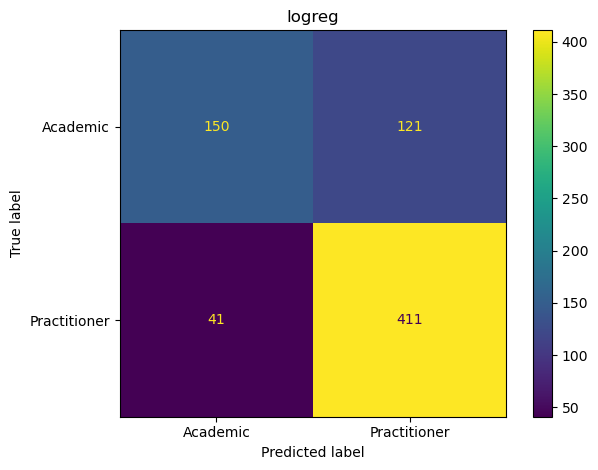

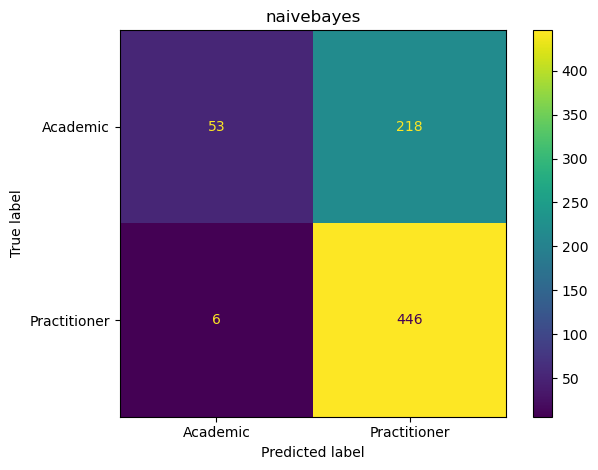

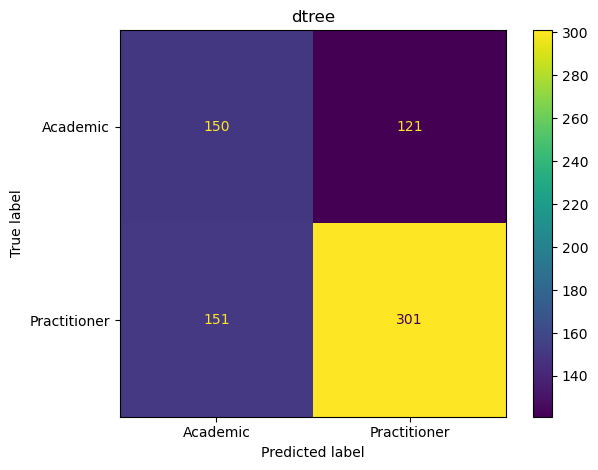

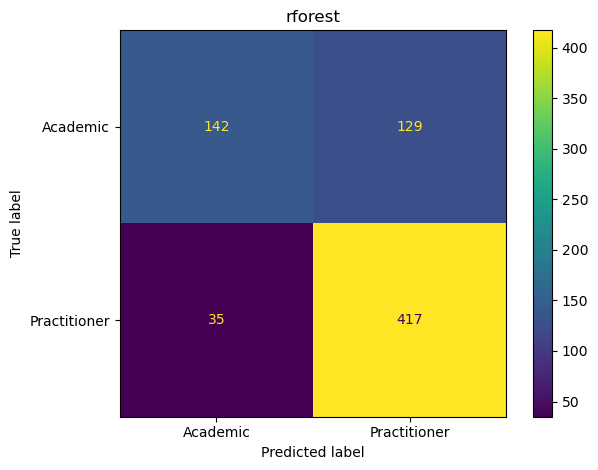

In [29]:
for report, model in enumerate(["logreg", "naivebayes", "dtree", "rforest"]):
    pd.DataFrame(classification_reports[report]).to_csv(f"../results/{model}_classification_report.csv")

    disp = ConfusionMatrixDisplay(confusion_matrices[report], display_labels=encoder.classes_)
    disp.plot()
    plt.title(model)
    plt.tight_layout()
    plt.savefig(f"../results/{model}_confusion_matrix")  